#setup

In [5]:
from google.colab import drive
import os 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !ls /content/drive/'My Drive'/$maindirectory/models/
%cd /content/drive/'My Drive'/my_detector2/models/research/
!protoc object_detection/protos/*.proto --python_out=.

os.environ['PYTHONPATH'] += ':/content/drive/My Drive/my_detector2/models/research/:/content/drive/My Drive/my_detector2/models/research/slim'
os.environ['PYTHONPATH'] += ':./:./slim/'

!python setup.py build
!python setup.py install

/content/drive/My Drive/my_detector2/models/research
running build
running build_py
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/mean_stddev_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/model_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/multiscale_anchor_generator_pb2.py -> build/lib/object_detection/protos
copyin

In [0]:
import cv2, numpy as np, tensorflow as tf, sys
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

graphname='frozen_inference_graph.pb'
directorywithgraph='fine_tuned_model'
maindirectory='my_detector2'
labelmapname='label_map.pbtxt'
NUM_CLASSES = 6

# path to the frozen graph:
PATH_TO_FROZEN_GRAPH = '/content/drive/My Drive/{0}/models/research/{1}/'.format(maindirectory, directorywithgraph) + graphname

# path to the label map
PATH_TO_LABEL_MAP = '/content/drive/My Drive/{0}/data/'.format(maindirectory) + labelmapname

# take webcam picture infere on picture 

In [17]:
# access webcam with some JS dom manipulation and code 

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

%cd /content

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

/content


In [18]:
# take the photo 
photo = take_photo('photo.jpg')
photo
image_path  = '/content/photo.jpg'

<IPython.core.display.Javascript object>

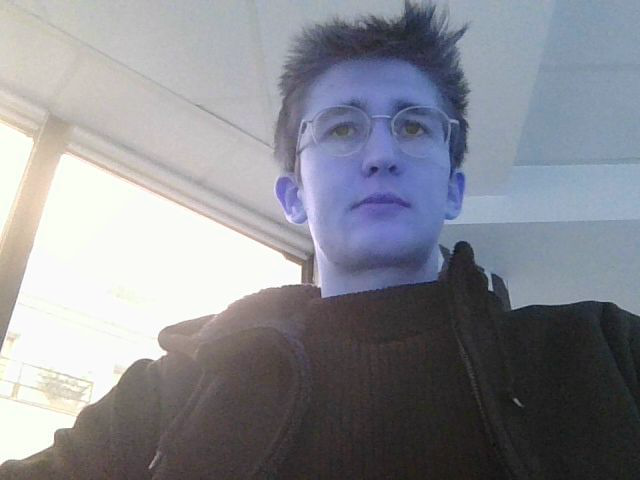

In [19]:
# display the photo
from PIL import Image
from google.colab.patches import cv2_imshow

img = np.array(Image.open('/content/photo.jpg'))
cv2_imshow(img)


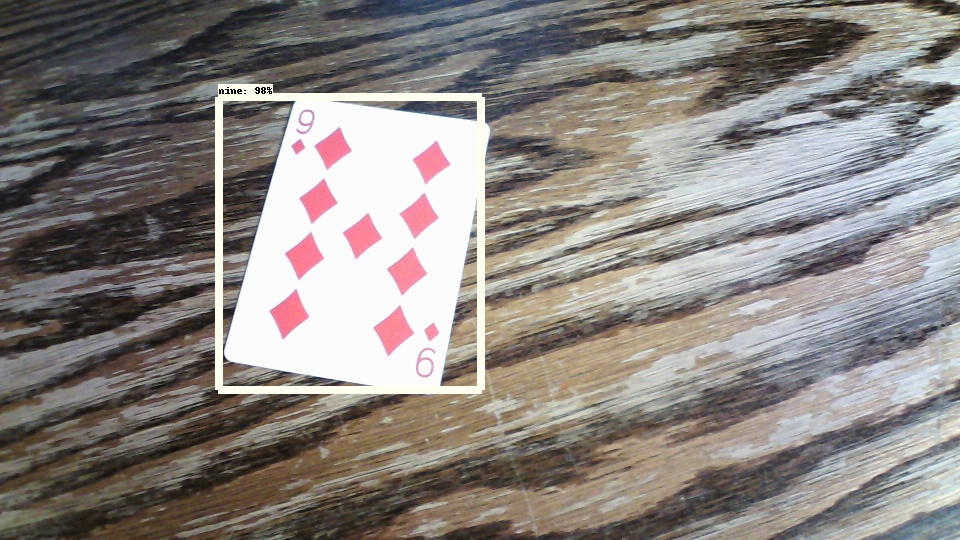

In [9]:
######## Image Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/15/18
# Description: 
# This program uses a TensorFlow-trained neural network to perform object detection.
# It loads the classifier and uses it to perform object detection on an image.
# It draws boxes, scores, and labels around the objects of interest in the image.

## Some of the code is copied from Google's example at
## https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

## and some is copied from Dat Tran's example at
## https://github.com/datitran/object_detector_app/blob/master/object_detection_app.py

## but I changed it to make it more understandable to me.

# Import packages
import os
import cv2
import numpy as np
import tensorflow as tf
import sys




# Path to image
PATH_TO_IMAGE = '/content/cam_image11.jpg'

# Number of classes the object detector can identify
NUM_CLASSES = 6

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.60)

# All the results have been drawn on image. Now display the image.
cv2_imshow(image)

# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()